In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Data import (careful: we use the 10% sample data for now)

## Original data

In [86]:
# data = pd.read_csv('data/bank.csv', sep=';')
# data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Attribute information:

* Input variables:
    * bank client data:
        1. age (numeric)
        2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                           "blue-collar","self-employed","retired","technician","services") 
        3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
        4. education (categorical: "unknown","secondary","primary","tertiary")
        5. default: has credit in default? (binary: "yes","no")
        6. balance: average yearly balance, in euros (numeric) 
        7. housing: has housing loan? (binary: "yes","no")
        8. loan: has personal loan? (binary: "yes","no")
    * related with the last contact of the current campaign:
        9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
        10. day: last contact day of the month (numeric)
        11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
        12. duration: last contact duration, in seconds (numeric)
    * other attributes:
        13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
        14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
        15. previous: number of contacts performed before this campaign and for this client (numeric)
        16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

* Output variable (desired target):
    * 
        17. y - has the client subscribed a term deposit? (binary: "yes","no")

## Data with additional features

In [88]:
data = pd.read_csv('data/bank-additional.csv', sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


<span style="color:#1f4068"></span> <span style="color:#e43f5a"></span>

## Data description

We noticed that features don't have exactly the same structure in both datasets. <span style="color:#1f4068">Particularities in the original dataset are highlighted in blue.</span> <span style="color:#e43f5a">Particularities in the additional dataset are highlighted in pink.</span>

* Input variables:
    * bank client data:
        1. age (numeric)
        2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
        3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
        4. education <span style="color:#1f4068">(categorical: "unknown","secondary","primary","tertiary")</span> <span style="color:#e43f5a">(categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")</span>
        5. default: has credit in default? <span style="color:#1f4068">(binary: "yes","no")</span> <span style="color:#e43f5a">(categorical: "no","yes","unknown")</span>
        6. <span style="color:#1f4068">balance: average yearly balance, in euros (numeric)</span>
        6. housing: has housing loan? <span style="color:#1f4068"> (binary: "yes","no")</span> <span style="color:#e43f5a">(categorical: "no","yes","unknown")</span>
        7. loan: has personal loan? <span style="color:#1f4068"> (binary: "yes","no")</span> <span style="color:#e43f5a">(categorical: "no","yes","unknown")</span>
    * related with the last contact of the current campaign:
        8. contact: contact communication type <span style="color:#1f4068">(categorical: "unknown","telephone","cellular")</span> <span style="color:#e43f5a">(categorical: "cellular","telephone")</span>
        9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
        10. <span style="color:#1f4068">day: last contact day of the month (numeric)</span>
        10. <span style="color:#e43f5a">day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")</span>
        11. duration: last contact duration, in seconds (numeric). **Important note:** this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
    * other attributes:
        12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
        13. pdays: number of days that passed by after the client was last contacted from a previous campaign <span style="color:#1f4068">(numeric, -1 means client was not previously contacted)</span> <span style="color:#e43f5a">(numeric; 999 means client was not previously contacted)</span>
        14. previous: number of contacts performed before this campaign and for this client (numeric)
        15. poutcome: outcome of the previous marketing campaign <span style="color:#1f4068">(categorical: "unknown","other","failure","success")</span> <span style="color:#e43f5a">(categorical: "failure","nonexistent","success")</span>
    * <span style="color:#e43f5a">social and economic context attributes
        16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
        17. cons.price.idx: consumer price index - monthly indicator (numeric)     
        18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
        19. euribor3m: euribor 3 month rate - daily indicator (numeric)
        20. nr.employed: number of employees - quarterly indicator (numeric)</span>

* Output variable (desired target):
    * 
        21. y - has the client subscribed a term deposit? (binary: "yes","no")

# Data exploration

## Output distribution

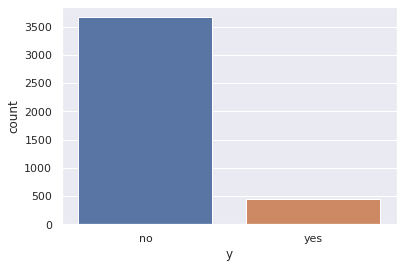

In [4]:
sns.countplot(x='y', data=data)
plt.show()

## Exploring relations between features

In [12]:
categorical_cols = data.columns[data.dtypes == 'object'].drop('y')
numerical_cols = data.columns.drop(categorical_cols).drop('y')
print('Categorical columns:\n', categorical_cols.to_list())
print('Numerical columns:\n', numerical_cols.to_list())

Categorical columns:
 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Numerical columns:
 ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


### Between categorical features

### Between categorical features and numerical features

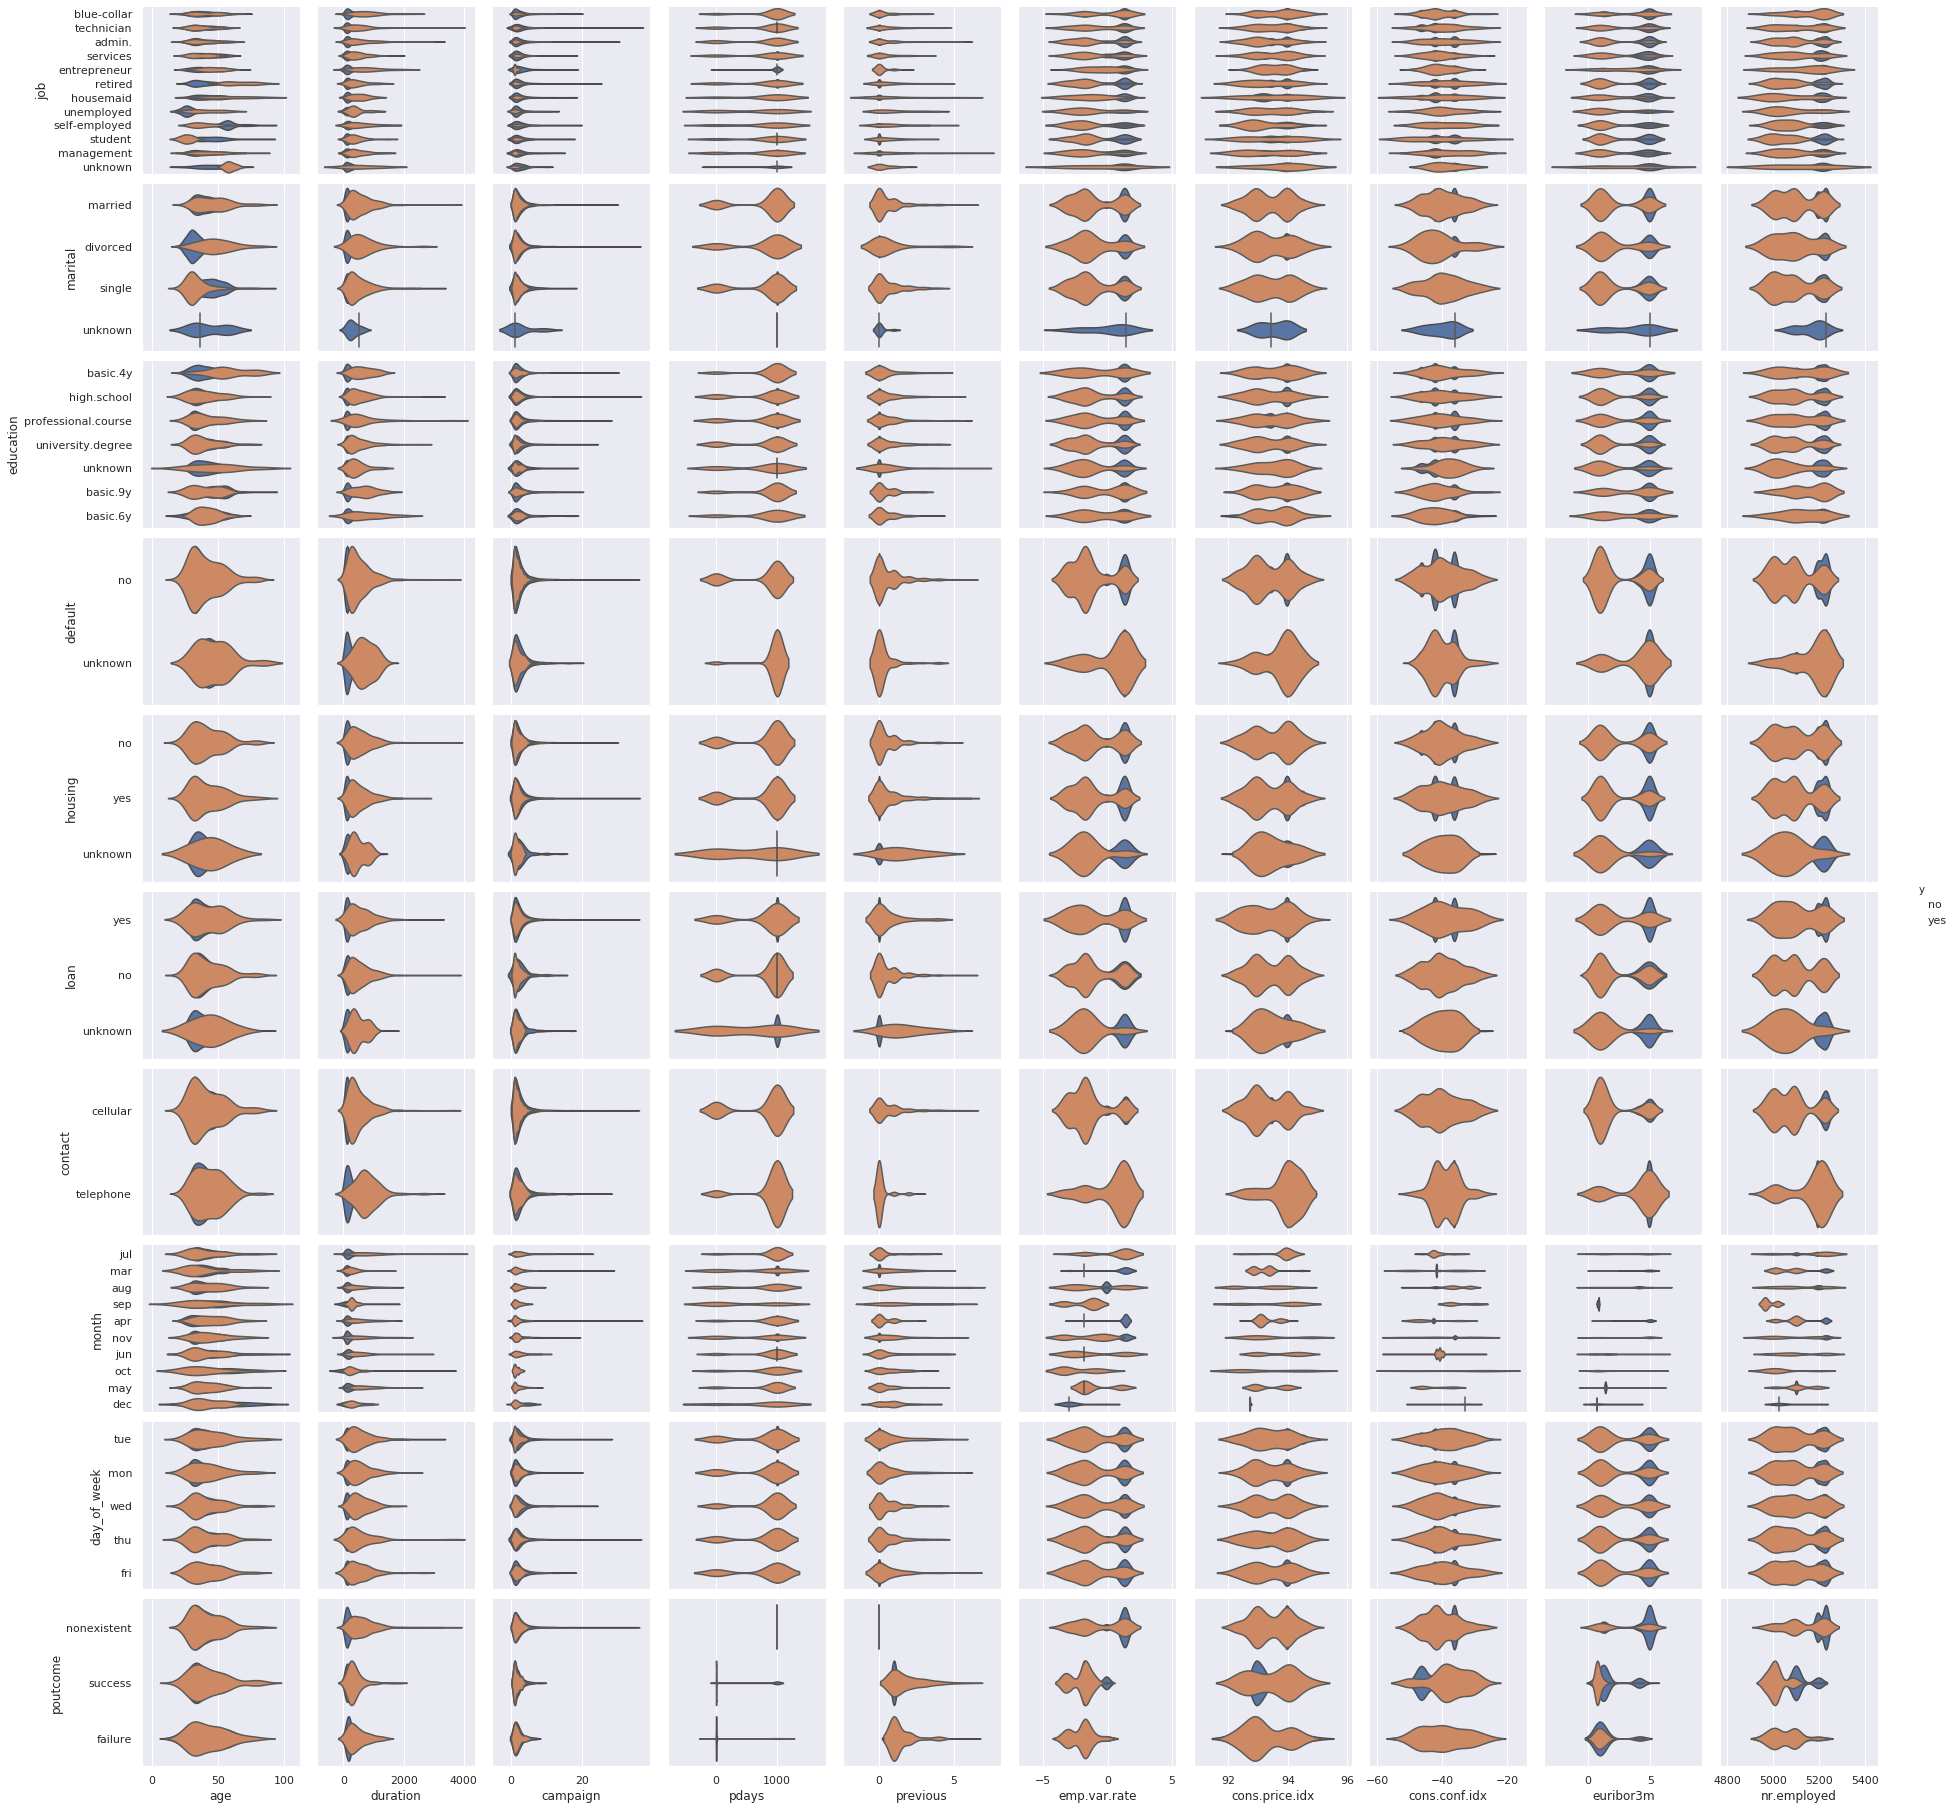

In [105]:
g = sns.PairGrid(data, x_vars=numerical_cols, y_vars=categorical_cols, hue='y')
g = g.map(sns.violinplot, inner=None, split=True) # split doesn't seem to work. It's supposed to draw two halves of the violin, one for each output
g = g.add_legend()
plt.show()

### Between numerical features

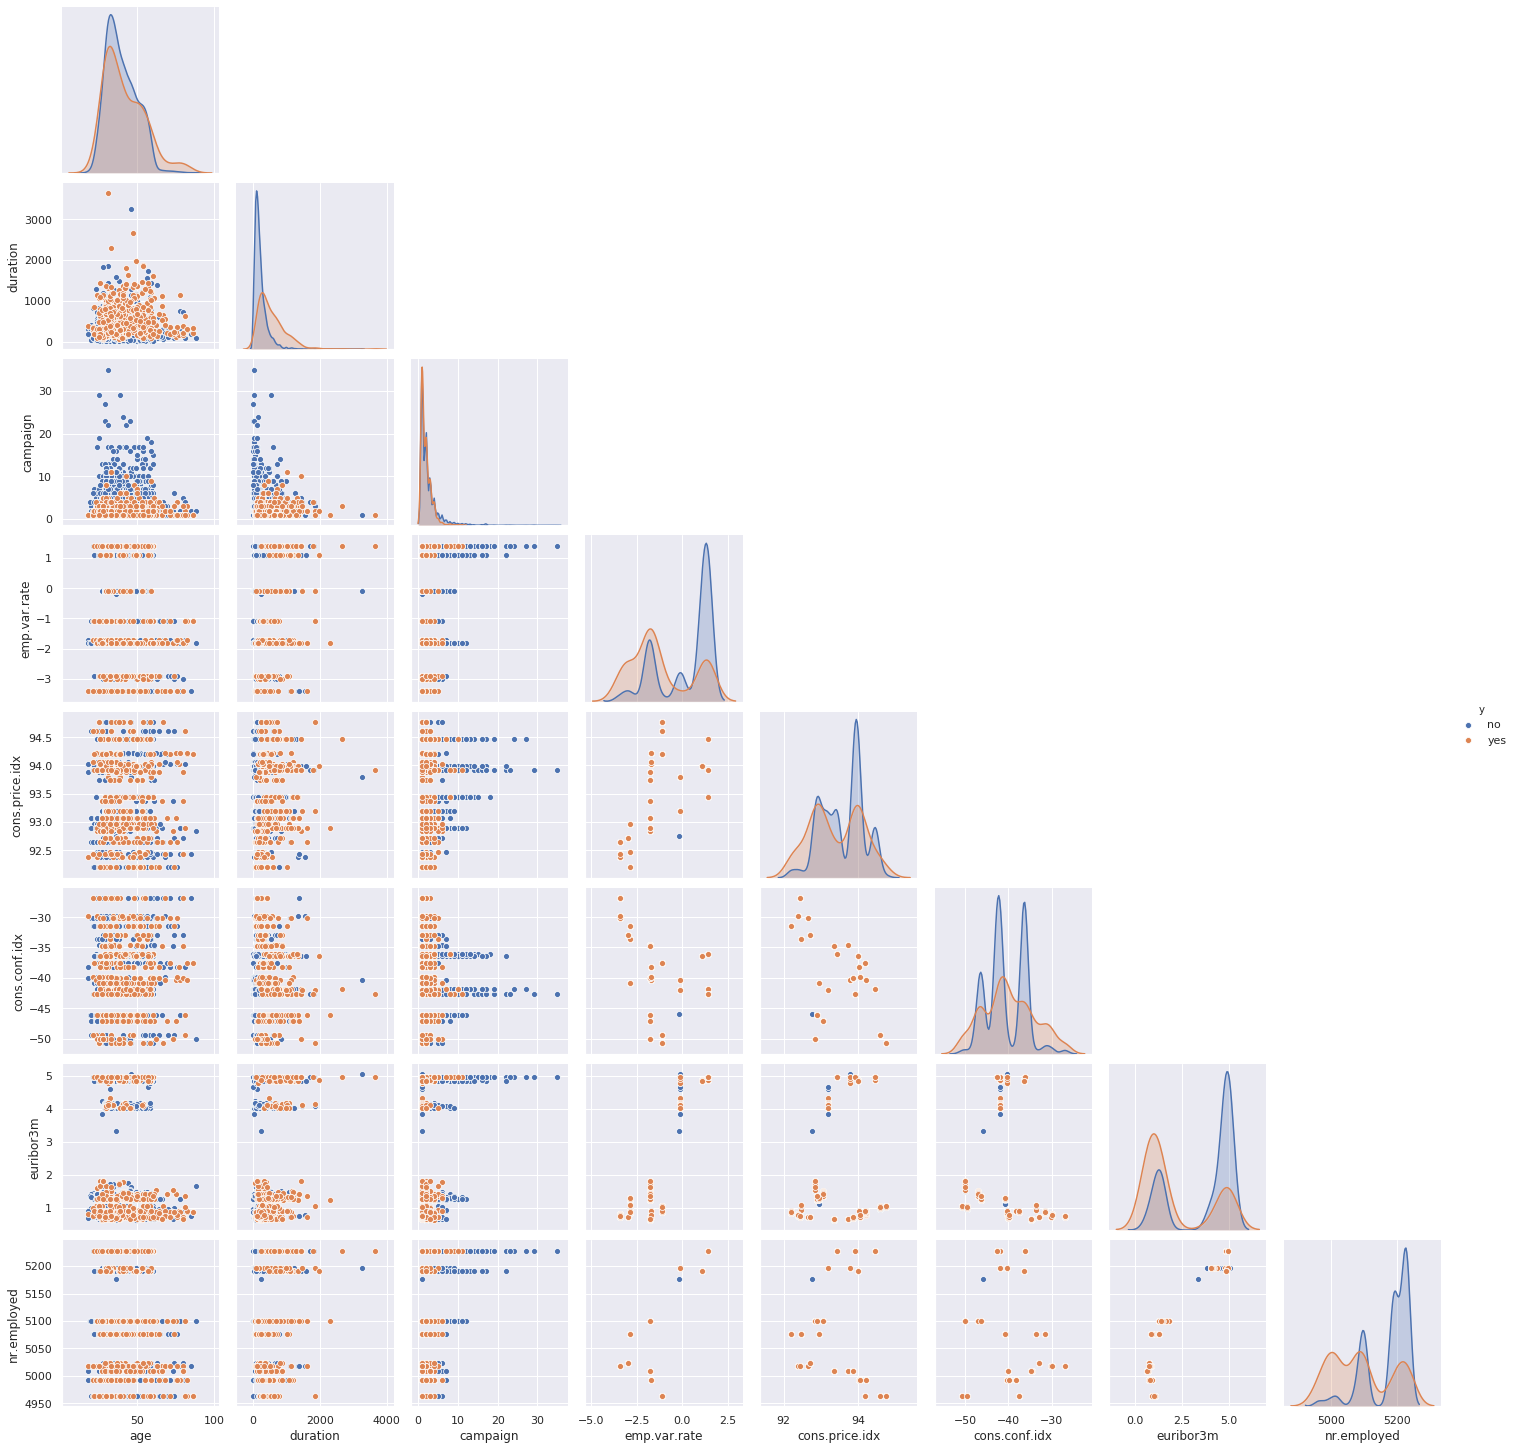

In [44]:
sns.pairplot(data, vars=numerical_cols.drop(['pdays', 'previous']), hue='y', corner=True) # kde plots for 'pdays' and 'previous' features give errors
plt.show()

# Neural net

## Data pre-processing

### One-hot encoding

In [106]:
onehot_data = pd.get_dummies(data)
onehot_data.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oc

### Min-max scaler for feature columns

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

### Creating tensors

In [66]:
x = torch.tensor(scaler.fit_transform(onehot_data.drop(columns=['y_no', 'y_yes']).values))
y = torch.tensor(onehot_data[['y_no', 'y_yes']].values)
print('Input shape: ', x.shape, '\nOutput shape: ', y.shape)

Input shape:  torch.Size([4119, 63]) 
Output shape:  torch.Size([4119, 2])


## Building neural net

In [62]:
class ClassificationNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(ClassificationNet, self).__init__()
        
        self.D_in = D_in
        self.H = H
        self.D_out = D_out
        
        self.linear1 = nn.Linear(self.D_in, self.H) 
        self.linear2 = nn.Linear(self.H, self.H)
        self.linear_out = nn.Linear(self.H, self.D_out) 
        
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.1)
#         self.batchnorm1 = nn.BatchNorm1d(64)
#         self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        y_pred = self.linear1(x).clamp(min=0)
#         y_pred = self.batchnorm1(y_pred)
        y_pred = self.linear2(y_pred).clamp(min=0)
#         y_pred = self.batchnorm2(y_pred)
#         y_pred = self.dropout(y_pred)
        y_pred = F.softmax(self.linear_out(y_pred))
        
        return y_pred

In [63]:
model = ClassificationNet(63, 128, 2)
print(model)

ClassificationNet(
  (linear1): Linear(in_features=63, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear_out): Linear(in_features=128, out_features=2, bias=True)
)


In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x.double())

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'mat1' in call to _th_addmm